 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [56]:
# !pip install torchvision

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

Скачаем обучающую и контрольную выборки.

In [167]:
import torch
from torchvision import datasets, transforms
import helper

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()])

#transforms.ToTensor() convert our image to a tensor
#transforms.Normalize() will normalizae our image with provided mean and sd values

# Download and load training data

trainset = datasets.FashionMNIST('./data',download=True, train= True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size= 64, shuffle=True)

# Download and load test data
testset = datasets.FashionMNIST('./data',download=True, train= False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size= 64, shuffle=True)

Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot| 

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

In [68]:
trainset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [69]:
testset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

60 тысяч картинок в трейне и 10 тысяч в тесте

In [32]:
trainset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [33]:
for i in trainset.targets.unique():
    print(f'{i} class has {(trainset.targets == i).sum()} entries')

0 class has 6000 entries
1 class has 6000 entries
2 class has 6000 entries
3 class has 6000 entries
4 class has 6000 entries
5 class has 6000 entries
6 class has 6000 entries
7 class has 6000 entries
8 class has 6000 entries
9 class has 6000 entries


In [34]:
for i in trainset.targets.unique():
    print(f'{i} class has {(testset.targets == i).sum()} entries')

0 class has 1000 entries
1 class has 1000 entries
2 class has 1000 entries
3 class has 1000 entries
4 class has 1000 entries
5 class has 1000 entries
6 class has 1000 entries
7 class has 1000 entries
8 class has 1000 entries
9 class has 1000 entries


Распределение классов в трейне и тесте одинаково равномерное

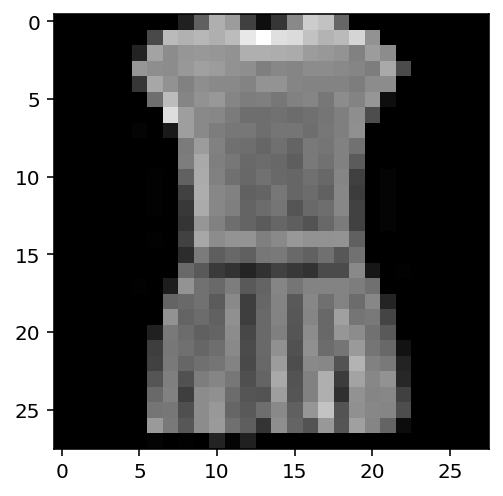

In [35]:
plt.imshow(trainset.data[3], cmap='gray');

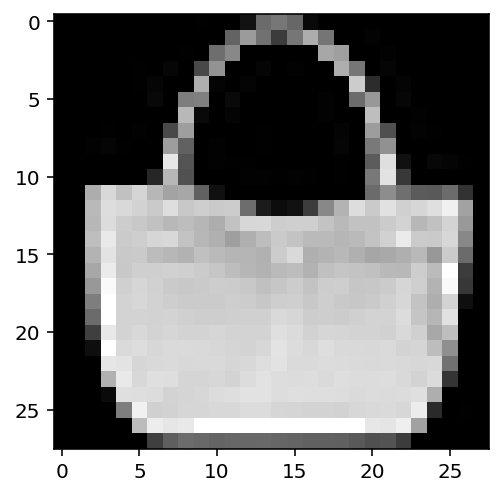

In [36]:
plt.imshow(trainset.data[100], cmap='gray');

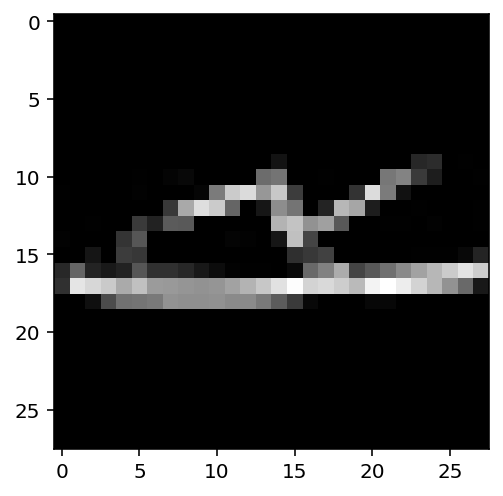

In [37]:
plt.imshow(trainset.data[32115], cmap='gray');

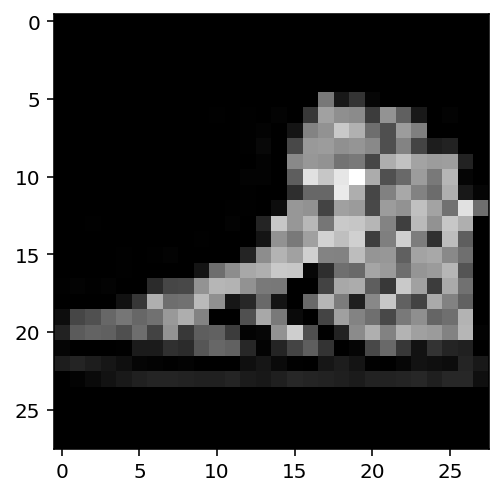

In [38]:
plt.imshow(testset.data[6666], cmap='gray');

torch.Size([64, 784])

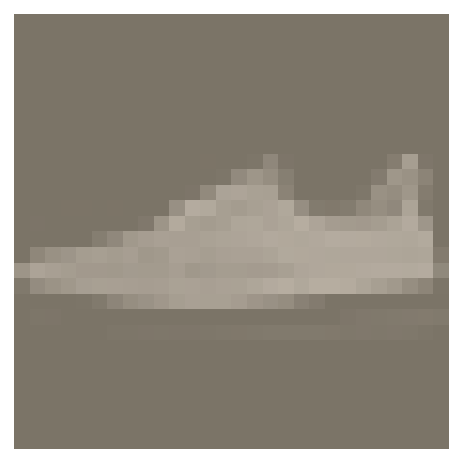

In [70]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:])
image.view(image.shape[0],-1).shape

In [113]:
image.view(image.shape[0],-1).shape

torch.Size([64, 784])

In [184]:
#Network parameters

input_size = 784 #i.e 28*28*1 
hidden_size = [512,256,128,64]
out_size = 10

In [186]:
from torch import nn
from torch.nn import NLLLoss
from torch.optim import SGD

model = nn.Sequential(
nn.Linear(input_size,hidden_size[0]),
nn.ReLU(),
nn.Linear(hidden_size[0],hidden_size[1]),
nn.ReLU(),
nn.Linear(hidden_size[1],hidden_size[2]),
nn.ReLU(),
nn.Linear(hidden_size[2],hidden_size[3]),
nn.ELU(),
nn.Linear(hidden_size[3],out_size),
nn.LogSoftmax(dim=1)
)

criterion = torch.nn.CrossEntropyLoss(size_average=False)
optimizer = SGD(model.parameters(),lr=0.001)

/home/alexanderlakiza/.virtualenvs/cs493/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [187]:
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ELU(alpha=1.0)
  (8): Linear(in_features=64, out_features=10, bias=True)
  (9): LogSoftmax(dim=1)
)


In [188]:
epochs = 15
losses = []
training_losses = []

for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    
    #Flatten the image into a 784 long vector
    
    images = images.view(images.shape[0],-1) #sqash the image in to 784*1 vector
    
    #reset the default gradients
    optimizer.zero_grad()
    
    # forward pass
    output = model(images)
    loss = criterion(output,labels)
    
    
    #backward pass calculate the gradients for loss
    loss.backward()
    
    # update the parameters
    optimizer.step()
    
    running_loss = running_loss+loss.item()
    losses.append(running_loss)
  else:
    print(f"Training loss: {running_loss/len(trainloader)}")
    training_losses.append(running_loss/len(trainloader))

Training loss: 61.96462333532793
Training loss: 33.30145321522694
Training loss: 27.911262440020597
Training loss: 24.800131703236463
Training loss: 22.655711694058578
Training loss: 21.202962564761197
Training loss: 19.988623328300427
Training loss: 19.18022334804413
Training loss: 18.301413052117645
Training loss: 17.67885450971152
Training loss: 16.953245303269895
Training loss: 16.342053187681415
Training loss: 15.980224401966087
Training loss: 15.301267388024565
Training loss: 14.863599343594712


tensor([[-1.1636e+01, -2.1471e+01, -1.8915e+01, -1.5633e+01, -1.4113e+01,
         -1.4302e+01, -1.6720e+01, -1.5214e+01, -1.0490e-05, -1.7320e+01]])
tensor([[8.8429e-06, 4.7325e-10, 6.1015e-09, 1.6240e-07, 7.4289e-07, 6.1494e-07,
         5.4760e-08, 2.4699e-07, 9.9999e-01, 3.0070e-08]])


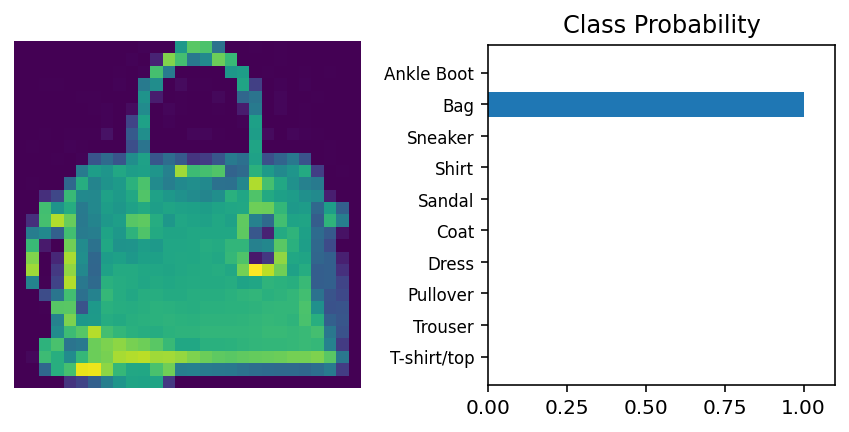

In [189]:
dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

#turn off the gradients
with torch.no_grad():
    print(model(img))
    logps = model(img)

ps = torch.exp(logps)
print(ps)

# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28), ps, version='Fashion')



In [190]:
X_test = testset.data.resize_(10000, 1, 784)

In [191]:
X_test = X_test.float()

In [192]:
preds = []

for i in range(10000):
    temp = model(X_test[i])
    temp_2 = torch.exp(temp)
    temp_2 = temp_2.detach().numpy()
    preds.append(np.argmax(temp_2))

In [193]:
print(len(preds))

10000


In [194]:
from sklearn.metrics import accuracy_score

accuracy_score(testset.targets, preds)

0.7804

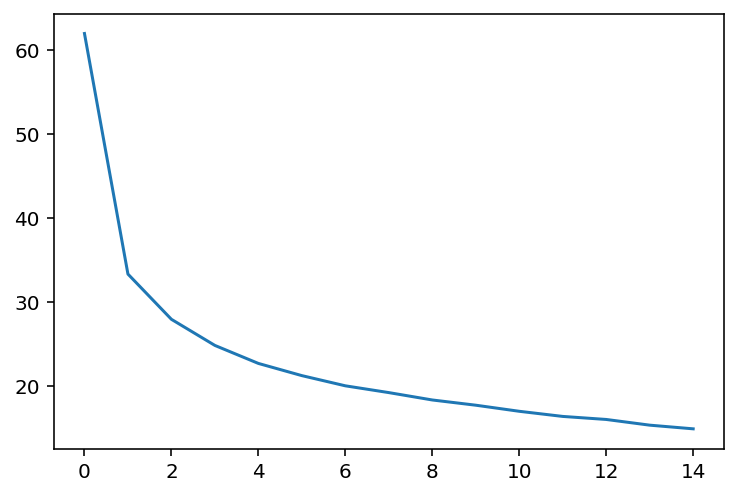

In [196]:
plt.plot(training_losses)